# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing.text import *
from sklearn.decomposition import PCA

import tqdm
import re
import string

# Load Data

In [2]:
url_path = 'https://sherlock-holm.es/stories/plain-text/advs.txt'

In [3]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', url_path)
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

610921/610921 [==============================] - 1s 1us/step


In [4]:
# put all text line in a list
text_list = []
for text in text_ds.as_numpy_iterator():
  text_list.append(text.strip().decode('utf-8'))

# Section 1

## Preprocessing

In [5]:
def preprocessing(text):
    # make text lowercase
    text = str(text).lower()

    # remove punctuations
    english_punctuations = string.punctuation
    translator = str.maketrans('', '', english_punctuations)
    return text.translate(translator)

In [6]:
preprocessed_text_list = [preprocessing(text) for text in text_list]

In [7]:
# save all words in corpus list
corpus = []
for text in preprocessed_text_list:
  corpus.extend(text.split())

## Generate samples of skipgram

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word2id = tokenizer.word_index

In [9]:
# convert all words in corpus to id
wids = [word2id[w] for w in corpus]

In [10]:
vocab_size = len(word2id) + 1
vocab_size

8427

In [11]:
num_ns = 4
pairs, labels = tf.keras.preprocessing.sequence.skipgrams(wids, vocabulary_size=vocab_size,
    window_size=4, negative_samples=num_ns, shuffle=True,
    categorical=False, sampling_table=None)

In [12]:
labels[:10]

[1, 1, 1, 0, 1, 0, 0, 1, 1, 0]

In [13]:
pairs[:10]

[[42, 21],
 [26, 12],
 [3216, 2087],
 [311, 4692],
 [2, 5544],
 [3267, 1213],
 [36, 7642],
 [398, 276],
 [4, 1515],
 [78, 4474]]

In [14]:
len(pairs)

4180740

In [15]:
targets = [row[0] for row in pairs]
contexts = [row[1] for row in pairs]

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

In [16]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000

# create dataset
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

## Model

In [24]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="target_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=1,
                                       name="context_embedding")
    self.dense_1 = layers.Dense(1, activation="sigmoid")

  def call(self, pair):
    target = pair[0]
    context = pair[1]

    word_emb = self.target_embedding(target)
    context_emb = self.context_embedding(context)

    dots = layers.dot([word_emb, context_emb], axes=1, normalize=False)
    output = self.dense_1(dots)

    return output

In [25]:
embedding_dim = 100
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

## Train Model

In [26]:
word2vec.fit(dataset, epochs=30)

Epoch 1/30
4082/4082 [==============================] - 62s 14ms/step - loss: 0.2701 - accuracy: 0.9091
Epoch 2/30
4082/4082 [==============================] - 26s 6ms/step - loss: 0.2279 - accuracy: 0.9175
Epoch 3/30
4082/4082 [==============================] - 26s 6ms/step - loss: 0.2097 - accuracy: 0.9216
Epoch 4/30
4082/4082 [==============================] - 26s 6ms/step - loss: 0.1866 - accuracy: 0.9270
Epoch 5/30
4082/4082 [==============================] - 25s 6ms/step - loss: 0.1655 - accuracy: 0.9334
Epoch 6/30
4082/4082 [==============================] - 27s 7ms/step - loss: 0.1517 - accuracy: 0.9384
Epoch 7/30
4082/4082 [==============================] - 24s 6ms/step - loss: 0.1440 - accuracy: 0.9412
Epoch 8/30
4082/4082 [==============================] - 24s 6ms/step - loss: 0.1396 - accuracy: 0.9428
Epoch 9/30
4082/4082 [==============================] - 25s 6ms/step - loss: 0.1368 - accuracy: 0.9437
Epoch 10/30
4082/4082 [==============================] - 27s 7ms/step - 

## Get Embeddings and create word vectors

In [27]:
weights = word2vec.get_layer('target_embedding').get_weights()[0] + word2vec.get_layer('context_embedding').get_weights()[0]

In [28]:
weights.shape

(8427, 100)

# Section 2

In [29]:
result = weights[word2id['king']] - weights[word2id['man']] + weights[word2id['woman']]

In [30]:
queen_vector = weights[word2id['queen']]

In [31]:
# similarity of two vectors
dot_product_result = np.dot(queen_vector, result)

In [32]:
# get probability
sigmoid = 1/(1+np.exp(-dot_product_result))

In [33]:
dot_product_result

26.133629

In [34]:
sigmoid

0.99999999999553

# Section 3

In [35]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(weights)

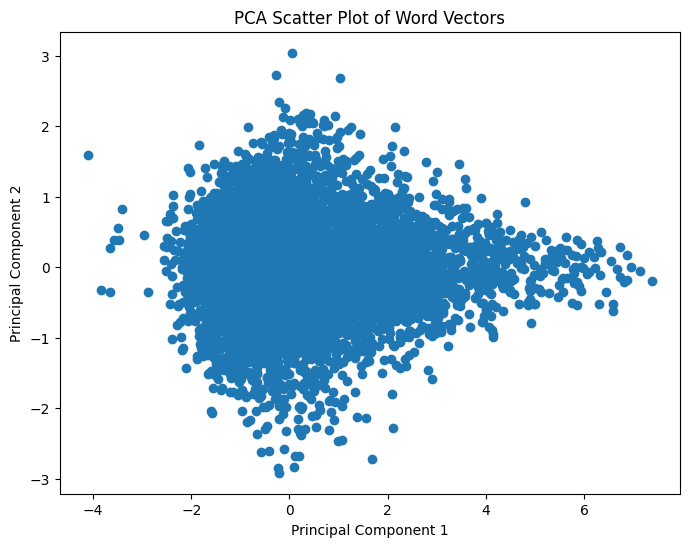

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1])

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot of Word Vectors")

# Show the plot
plt.show()

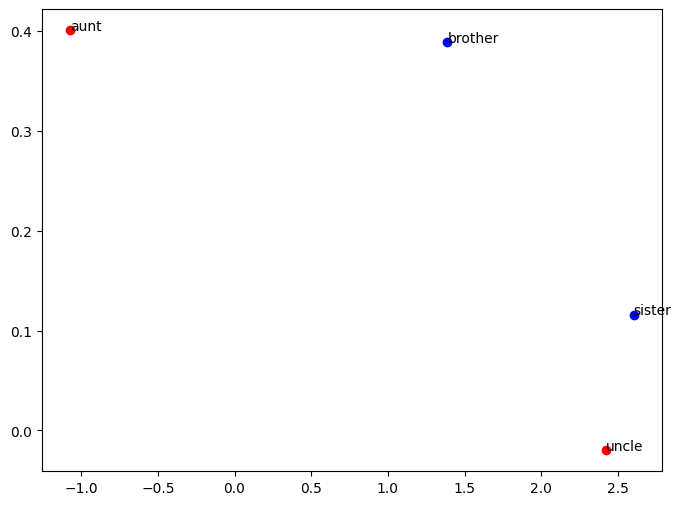

In [37]:
brother_vector = pca_result[word2id['brother']]
sister_vector = pca_result[word2id['sister']]
uncle_vector = pca_result[word2id['uncle']]
aunt_vector = pca_result[word2id['aunt']]
plt.figure(figsize=(8,6))

plt.scatter(brother_vector[0], brother_vector[1], c='blue')
plt.annotate('brother', (brother_vector[0], brother_vector[1]))
plt.scatter(sister_vector[0], sister_vector[1], c='blue')
plt.annotate('sister', (sister_vector[0], sister_vector[1]))

plt.scatter(uncle_vector[0], uncle_vector[1], c='red')
plt.annotate('uncle', (uncle_vector[0], uncle_vector[1]))
plt.scatter(aunt_vector[0], aunt_vector[1], c='red')
plt.annotate('aunt', (aunt_vector[0], aunt_vector[1]))

plt.show()

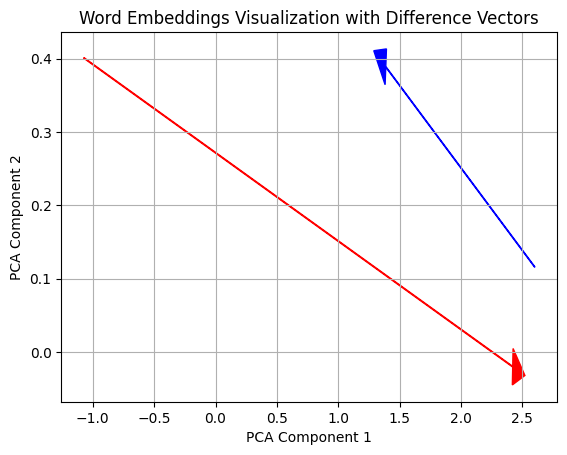

In [38]:
# Calculate difference vectors
diff_vector_1 = brother_vector - sister_vector  # brother - sister
diff_vector_2 = uncle_vector - aunt_vector  # uncle - aunt

# Draw difference vectors
plt.arrow(sister_vector[0], sister_vector[1], diff_vector_1[0], diff_vector_1[1], head_width=0.05, head_length=0.1, fc='blue', ec='blue')
plt.arrow(aunt_vector[0], aunt_vector[1], diff_vector_2[0], diff_vector_2[1], head_width=0.05, head_length=0.1, fc='red', ec='red')

plt.title('Word Embeddings Visualization with Difference Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()